<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2021/blob/master/07_lab/lab7_GANs_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial networks

Let's do our usual imports + use a tool to download the dataset we'll use today:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow_datasets as tfds
from tqdm import tqdm
from PIL import Image

The code below will download and preprocess the dataset we'll work with today:

In [ ]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete1JF967/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

100%|██████████| 13233/13233 [00:14<00:00, 934.55it/s]


Let's have a look at the shape of the dataset:

In [ ]:
print("shape:", data.shape)
print("min, max:", data.min(), data.max())

shape: (13233, 3, 36, 36)
min, max: 0.0 1.0


So far our data has the following shape: (n_images, height, width, n_channels). PyTorch convolutional layers want the channels dimension to be the second one (axis=1), so let's transpose (and normalize) the data:

In [ ]:
data = data.transpose(0, 3, 1, 2).astype(np.float32) / 255.

And here's a function to plot a (optionally random) subset of images:

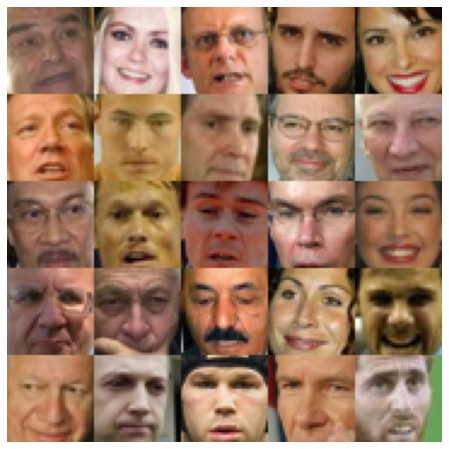

In [ ]:
def plot_mn(images, m=5, n=5, shuffle=True):
  if shuffle:
    images = images[np.random.permutation(len(images))[:m * n]]
  h, w = images.shape[2:]
  images = images[:m*n].reshape(m, n, *images.shape[1:]).transpose(0, 1, 3, 4, 2) # plotting requires channels last
  images = images.transpose(0, 2, 1, 3, 4).reshape(m * h, n * w, -1)
  plt.imshow(images)

plt.figure(figsize=(8, 8))
plot_mn(data)
plt.axis('off');

Finally, let's import torch and define the Reshape layer (same as in the convolutions notebook):

In [ ]:
import torch

class Reshape(torch.nn.Module):
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.reshape(x.shape[0], *self.shape)

Now, we'll take off from a very simple generator and discriminator:

In [27]:
latent_dims = 128
dropout_rate = 0.1

generator = torch.nn.Sequential(
    # torch.nn.Linear(latent_dims, 64),
    # torch.nn.ELU(),
    # torch.nn.Dropout(p=dropout_rate),
    # torch.nn.Linear(64, 3 * 36 * 36),
    # torch.nn.ELU(),
    # Reshape(3, 36, 36)

    torch.nn.Linear(latent_dims, 64),
    torch.nn.ELU(),
    Reshape(1, 8, 8),

    torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=0), # 6x6
    torch.nn.ELU(),
    torch.nn.Upsample(scale_factor=2), # 12x12

    torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # 12x12
    torch.nn.ELU(),
    torch.nn.Upsample(scale_factor=2), # 24x24

    torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=0), # 22x22
    torch.nn.ELU(),
    torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=0), # 20x20
    torch.nn.ELU(),
    torch.nn.Upsample(scale_factor=2), # 40x40

    torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=0), # 38x38
    torch.nn.ELU(),

    torch.nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=0), # 36x36
    torch.nn.ELU()
).cuda()

discriminator = torch.nn.Sequential(
    # Reshape(3 * 36 * 36),
    # torch.nn.Linear(3 * 36 * 36, 128),
    # torch.nn.ELU(),
    # torch.nn.Dropout(p=dropout_rate),
    # torch.nn.Linear(128, 1),

    torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1), # 36x36
    torch.nn.ELU(),
    torch.nn.MaxPool2d(2), # 18x18

    torch.nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=0), # 16x16
    torch.nn.ELU(),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 16x16
    torch.nn.ELU(),
    torch.nn.MaxPool2d(2), # 8x8

    torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0), # 6x6
    torch.nn.ELU(),
    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0), # 4x4
    torch.nn.ELU(),
    torch.nn.MaxPool2d(2), # 2x2

    Reshape(512),
    torch.nn.Linear(in_features=512, out_features=1)
).cuda()

def get_n_params(model):
  return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(generator))
print('discriminator params:', get_n_params(discriminator))

generator params: 403171
discriminator params: 243009


Then, we need a function to sample real and fake images:

In [28]:
def sample_images(batch_size):
  ids = np.random.choice(len(data), size=batch_size)
  return torch.tensor(data[ids]).cuda()

def sample_fake(batch_size):
  noise = torch.randn(batch_size, latent_dims).cuda()
  return generator(noise)

Let's have a look what we can generate before any training:

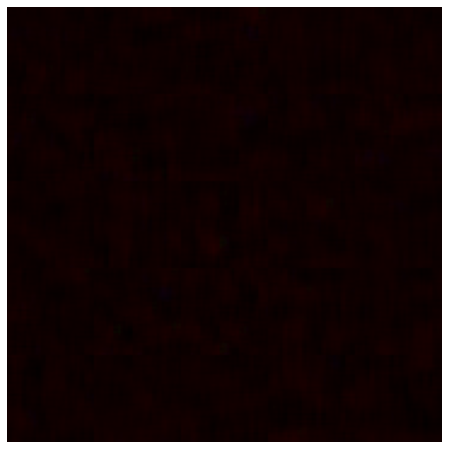

In [29]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plt.figure(figsize=(8, 8))
plot_mn(imgs.clip(0, 1))
plt.axis('off')
plt.show();

Ok, now that we have our model defined, we need our loss functions. Historically the first loss used in GANs is the cross-entropy that we already used so many times:
$$\mathscr{L}^{\text{discr}} =
-\text{E}\left[logD(x_{real})\right]
-\text{E}\left[log(1 - D(x_{fake}))\right] 
$$

And hence for the generator the loss is:

$$\mathscr{L}^{\text{gen}} =
-\text{E}\left[logD(x_{fake})\right]$$

Note that here $D(x)$ is the probability the discriminator assigns to $x$ to be from the real dataset, so it's $\sigma($ `discriminator` $(x))$.

Try implementing these loss functions below. Note that $1-\sigma(x)=\sigma(-x)$. You should use the `logsigmoid` as a stable realization of $log\cdot\sigma(x)$.

In [30]:
logsigmoid = torch.nn.functional.logsigmoid

def generator_loss(fake):
  return -logsigmoid(discriminator(fake)).mean()
  
def discriminator_loss(real, fake):
  return -(logsigmoid(discriminator(real)) + logsigmoid(-discriminator(fake))).mean()

Let's do some more set-up and run the learning process:

In [31]:
batch_size = 64

generator_losses = []
discriminator_losses = []

In [32]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)
optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)

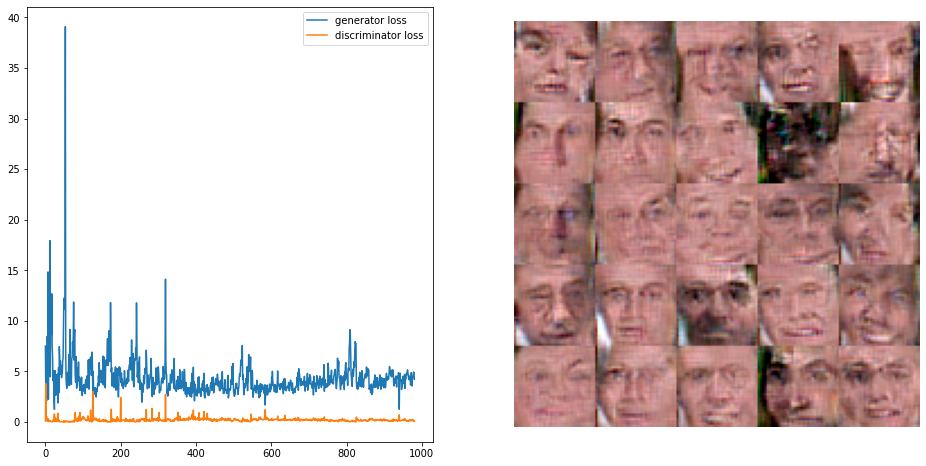

In [33]:
from IPython.display import clear_output


for i in range(1000):
  # Since our models are updated in turns,
  # we first set the discriminator to train,
  # while the generator is in the eval mode
  generator.eval()
  discriminator.train()
  
  # Several discriminator updates per step:
  for j in range(5):
    # Sampling reals and fakes
    real = sample_images(batch_size)
    fake = sample_fake(batch_size)
    
    # Calculating the loss
    loss = discriminator_loss(real, fake)
    
    # Doing our regular optimization step for the discriminator
    discriminator.zero_grad()
    loss.backward()
    optimizer_discriminator.step()

  # Remember the value of discriminator loss for plotting
  discriminator_losses.append(loss.item())

  # Now it's generator's time to learn:
  generator.train()
  discriminator.eval()

  loss = generator_loss(sample_fake(batch_size))
  generator_losses.append(loss.item())
  generator.zero_grad()
  loss.backward()
  optimizer_generator.step()

  if i % 20 == 0:
    generator.eval()
    imgs = sample_fake(25).cpu().detach().numpy()
    
    clear_output(wait=True)

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(generator_losses    , label='generator loss')
    plt.plot(discriminator_losses, label='discriminator loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plot_mn(imgs.clip(0, 1))
    plt.axis('off')
    plt.show();

Seems like it's working! Now try to impelment some convolutional architechtures to make our model more expressive.

You might face some instabilities as you go. The simplest regularization that can be done is **adding some random noize to the discriminator's input**.

Another good stabilization is adding a **discriminator gradient L2 penalty for real images only** (see this paper: https://arxiv.org/pdf/1801.04406.pdf):

```
def discriminator_penalty(real):
  real.requires_grad = True
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), real,
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty
```


You can also use **decreasing learning rate**:

```
# multiply the learning rate by 0.999 each 10 steps:
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_generator    , step_size=10, gamma=0.999)

# ...

# In the training loop:
  scheduler_d.step()
  scheduler_g.step()
```